# PG Diploma in Machine Learning and AI | IIIT Bangalore | Upgrad 

## Deep Learning Course Project - Gesture Recognition

### Problem Description
Imagine yourself in the role of a data scientist at a cutting-edge home electronics company specializing in smart televisions. Your task is to introduce an exciting new feature to these smart TVs - gesture recognition. This feature will enable users to control their televisions effortlessly without the need for a remote control.

The concept is simple: a webcam mounted on the TV continuously monitors and recognizes five distinct gestures made by the user, each corresponding to a specific command:

| Gesture     | Corresponding Action       |
| ----------- | -------------------------- |
| Thumbs Up   | Increase the volume.       |
| Thumbs Down | Decrease the volume.       |
| Left Swipe  | 'Jump' backward 10 seconds.|
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop        | Pause the movie.           |

Each video stream consists of a sequence of 30 frames (or images).

### Project Goals:
1. **Data Generator**: The data generator should smoothly handle batches of videos as input, seamlessly executing tasks like cropping, resizing, and normalization.

2. **Model Development**: Build a model that can train without errors. The model will be evaluated based on the total number of parameters (keeping inference time in mind) and its achieved accuracy. As suggested by Snehansu, begin training with a small dataset before scaling up.

3. **Documentation**: The project documentation should provide a comprehensive account of the methodology followed in selecting the final model. It should start by explaining the rationale behind choosing the base model and then delve into the considerations and metrics that influenced modifications and experiments, ultimately leading to the final model selection.

In [3]:
import numpy as np
import math
import os
import scipy
from imageio.v2 import imread
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image,ImageFilter,ImageEnhance
from skimage import io,transform
import tensorflow as tf
import random as rn

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 50

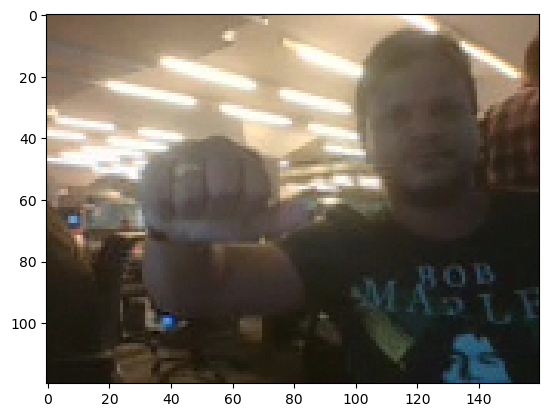

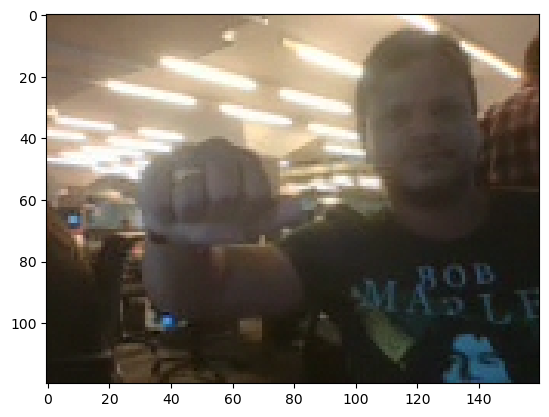

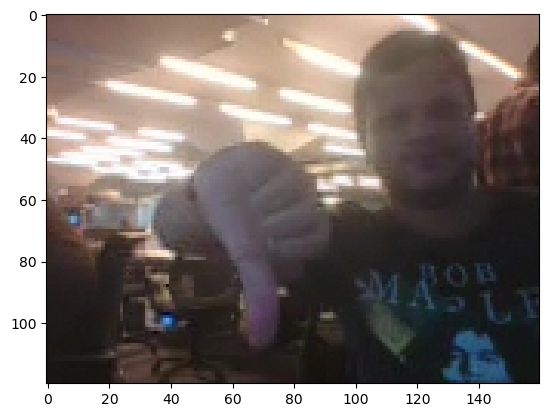

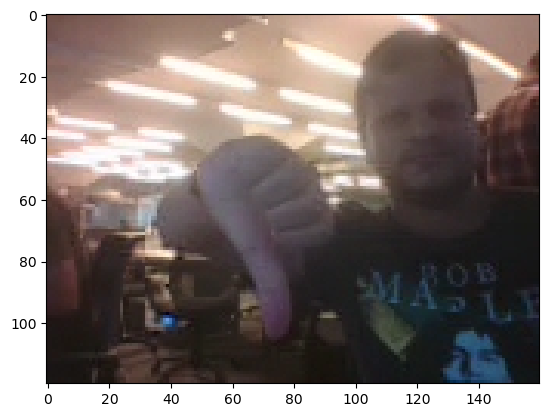

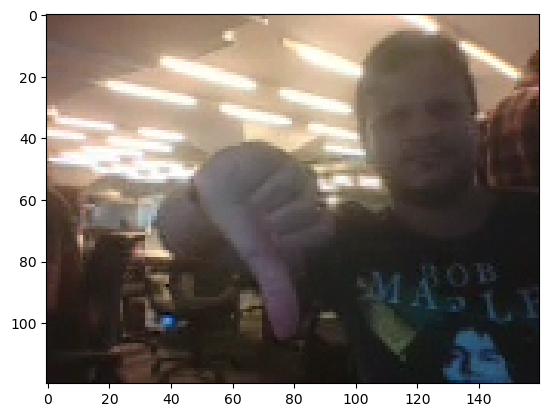

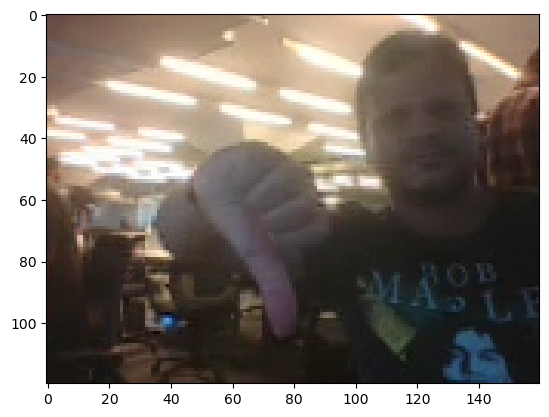

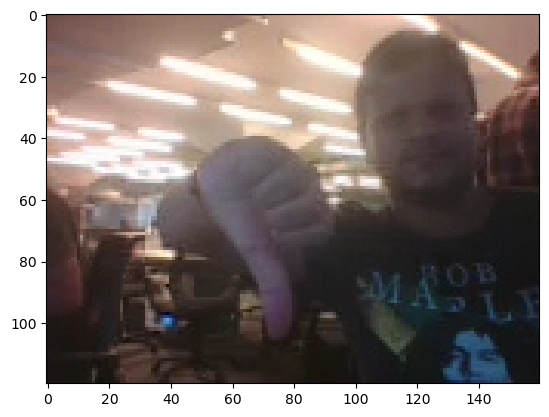

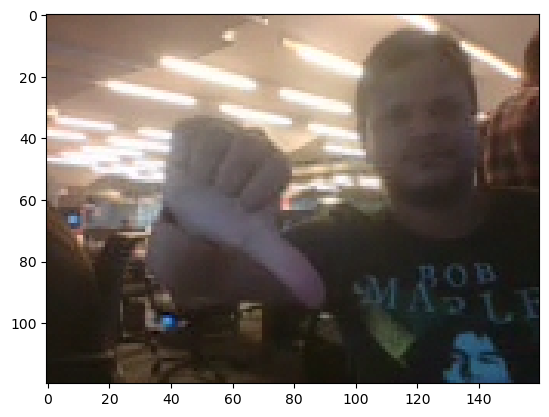

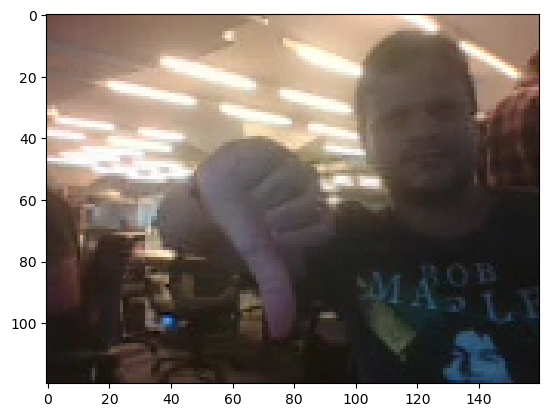

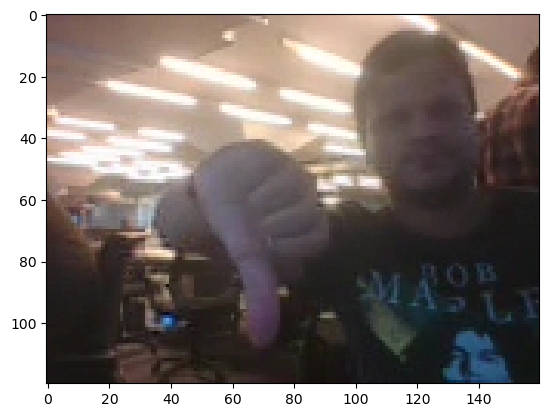

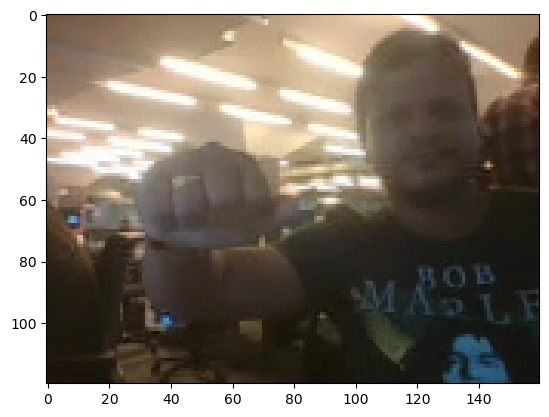

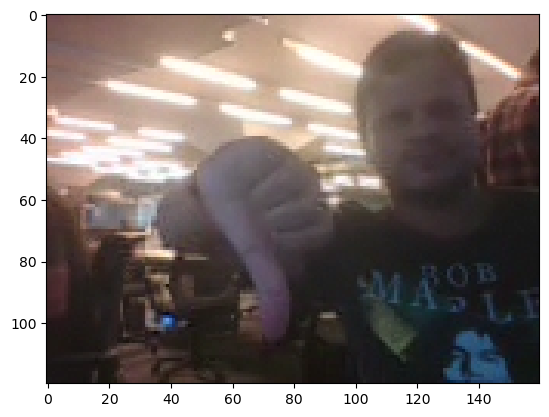

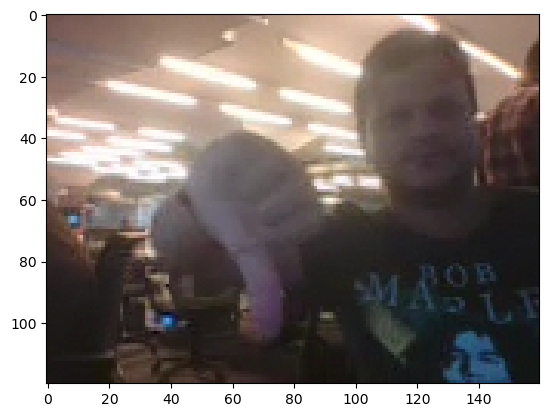

In [28]:
# visualizing a single video
video_path = './Project_data/train' + '/' + train_doc[1].strip().split(";")[0] 
videos = os.listdir(video_path)
img_idx = [0,2,4,8,10,12,14,16,18,20,22,25,29]

for idx in img_idx:
    image = imread(video_path + '/' + videos[idx])
    plt.imshow(image)
    plt.show()

In [6]:
print(len(train_doc),len(val_doc))

663 100


In [7]:
image_height = 120
image_width = 120
batch_size = 50
img_idx = [0,2,4,8,10,12,14,16,18,20,22,25,29]
image_size = 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size):
    print(len(source_path))
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_size,image_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path +'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.height == 360 :
                        image = image.resize((image_size,image_size),resample=Image.LANCZOS)
                    else:
                        image = image.crop((40,0,160,120))
                    
                    image_array = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image_array[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_array[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_array[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        
        if (len(folder_list) != batch_size*num_batches):
            
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch = num_batches
            batch_data = np.zeros((batch_size,len(img_idx),image_size,image_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path +'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in

                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.height == 360 :
                        image = image.resize((image_size,image_size), resample=Image.LANCZOS)
                    else:
                        image = image.crop((40,0,160,120))
                    image_array = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image_array[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_array[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_array[:,:,2]/255 #normalise and feed in the image
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D,GlobalAveragePooling2D,ConvLSTM2D,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNetV2

In [11]:
# function to plot history data saved by model

def plot_history(history):
    print('Total epochs trained: ' , len(history.history['categorical_accuracy']))
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1 

In [11]:


#write your model here

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=(len(img_idx),image_size,image_size,3)))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 120, 120, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 40, 40, 32)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 40, 40, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 40, 40, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 14, 14, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 14, 14, 64)     0

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
batch_size = 100
num_epochs = 15

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=2)# write the REducelronplateau code here

earlyStopping = EarlyStopping(monitor='val_loss', patience=4)

callbacks_list = [checkpoint, LR, earlyStopping]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

52
Source path =  /kaggle/input/hand-gesture-for-tv/Project_data/train ; batch size = 100
Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 1.6288 - categorical_accuracy: 0.215750
Source path =  /kaggle/input/hand-gesture-for-tv/Project_data/val ; batch size = 100

Epoch 1: saving model to model_init_2023-09-0312_37_54.756661/model-00001-1.62883-0.21569-1.58299-0.23000.h5
7/7 [==============================] - 81s 11s/step - loss: 1.6288 - categorical_accuracy: 0.2157 - val_loss: 1.5830 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 1.5748 - categorical_accuracy: 0.2290
Epoch 2: saving model to model_init_2023-09-0312_37_54.756661/model-00002-1.57483-0.22902-1.54728-0.23000.h5
7/7 [==============================] - 36s 6s/step - loss: 1.5748 - categorical_accuracy: 0.2290 - val_loss: 1.5473 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 1

Total epochs trained:  9


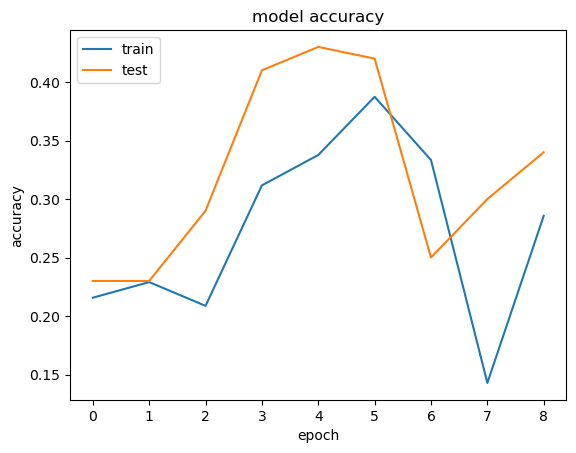

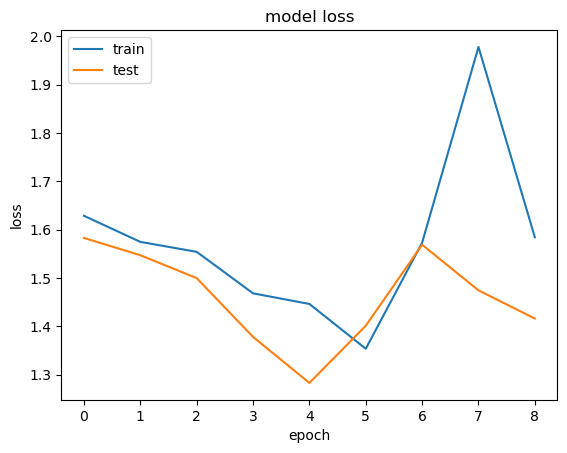

In [17]:
plot_history(history)

The model's accuracy is consistently below the 40-50% range, and it is likely that this issue can be attributed to the batch size. With a current batch size of 50, reducing it is expected to lead to an improvement in accuracy.

## Model 2

In [42]:
model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=(len(img_idx),image_size,image_size,3)))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

batch_size = 32
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 13, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 5, 40, 40, 32)     0         
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 40, 40, 64)     55360     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 2, 14, 14, 64)    0         
 g3D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 2, 14, 14, 64)    

Total epochs trained:  15


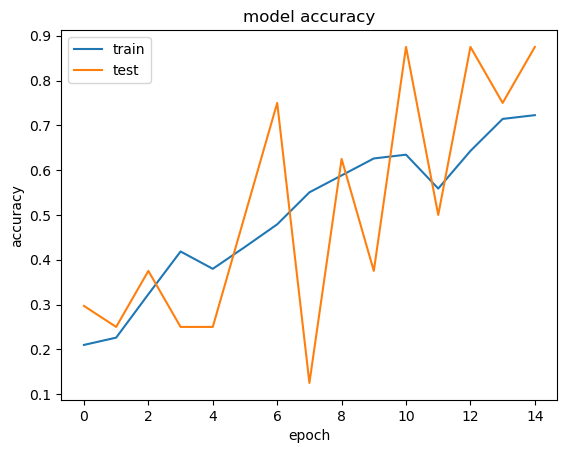

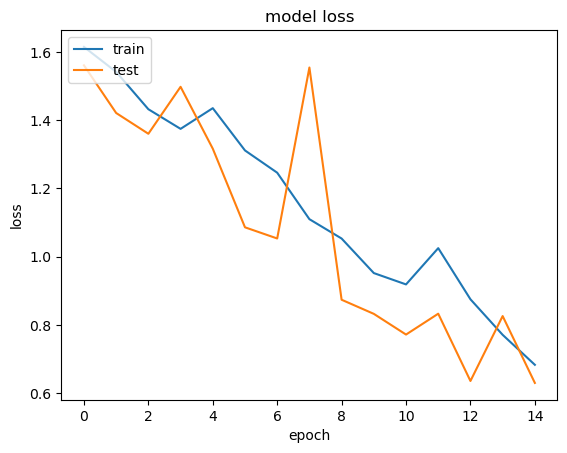

In [43]:
plot_history(history)

The model has achieved an accuracy of 80%, yet it continues to underperform. During specific epochs, the validation accuracy surpasses the training accuracy, suggesting that the model may lack the necessary complexity.

## Model 3

In [44]:
model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', activation='relu', input_shape=(len(img_idx),image_size,image_size,3)))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

batch_size = 32
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 13, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 40, 40, 32)     13856     
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 2, 14, 14, 32)    0         
 g3D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 2, 14, 14, 32)    

Total epochs trained:  11


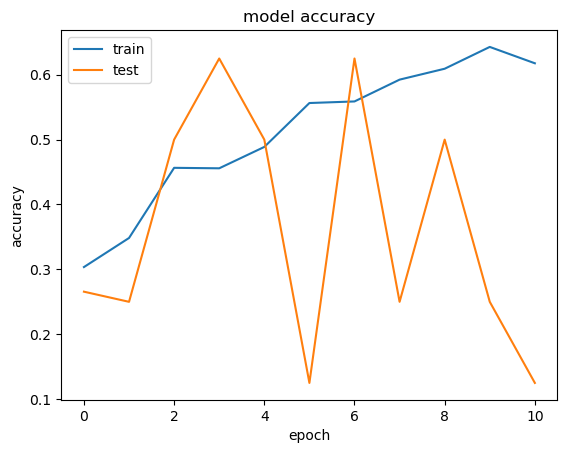

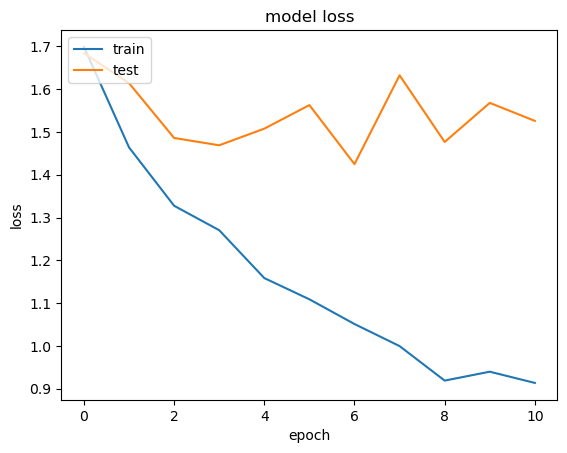

In [45]:
plot_history(history)

The model is exhibiting overfitting tendencies, so we will address this issue by reducing the number of convolutional layers and incorporating dropout layers.

## Model 4

In [48]:


#write your model here

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=(len(img_idx),image_size,image_size,3)))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.1))

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))

# ---
model.add(BatchNormalization())
# ---

model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


batch_size = 32
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 13, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 5, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 5, 40, 40, 32)     0         
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 40, 40, 64)     55360     
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 2, 14, 14, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 2, 14, 14, 64)   

Total epochs trained:  5


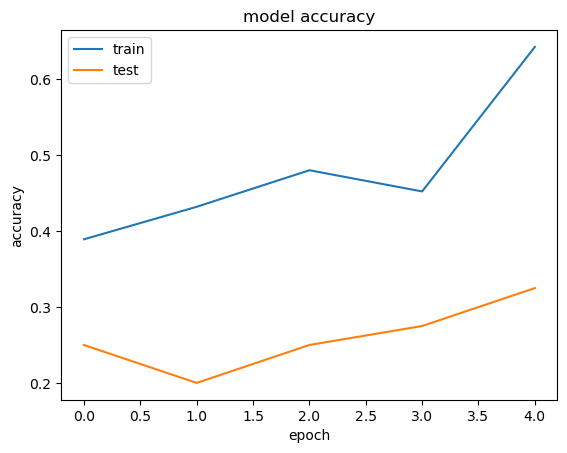

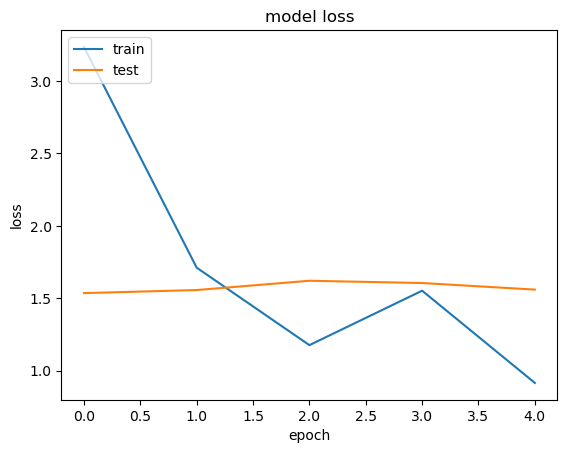

In [47]:
plot_history(history)

| Metric        | Value    |
|---------------|----------|
| Best Model    | Model 2  |
| Best Epoch    | 14/15    |
| Accuracy      | 0.7143   |
| Val Accuracy  | 0.75     |


## CNN2d + GRU

## Model 5 

Using a batch size of 32, as it yielded superior results in the context of 3D CNN.

In [13]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, LSTM, BatchNormalization, MaxPooling2D

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(len(img_idx),image_size,image_size,3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))

model.add(TimeDistributed(Flatten()))

model.add(GRU(128, dropout=0.2))

model.add(Dense(5, activation='softmax'))




optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


batch_size = 32
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 13, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 13, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 13, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 13, 30, 30, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 13, 30, 30, 64)   1

Total epochs trained:  7


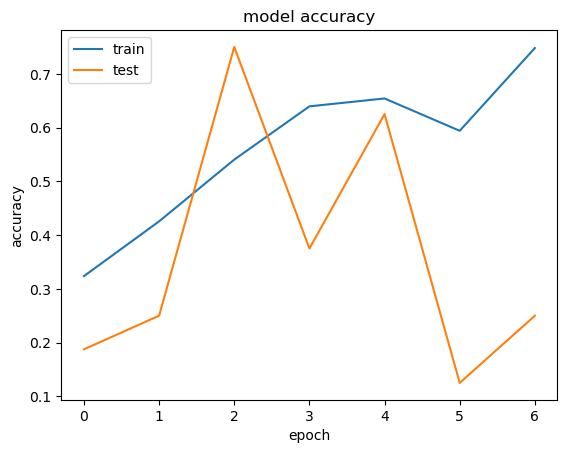

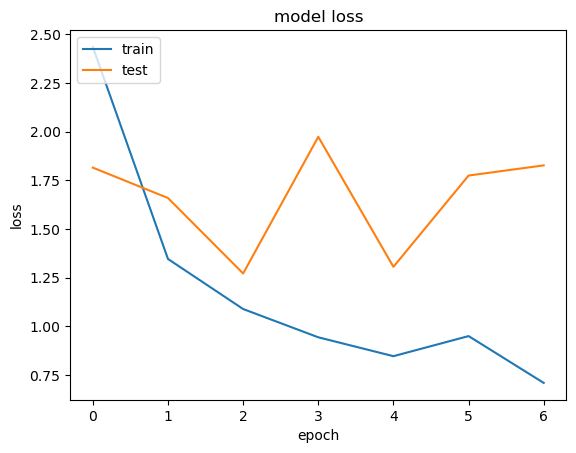

In [14]:
plot_history(history)

The model is experiencing overfitting, likely because of its excessive complexity.

## Model 6

In [23]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),input_shape=(len(img_idx),image_size,image_size,3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))

model.add(GRU(128, dropout=0.2))

model.add(Dense(5, activation='softmax'))




optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


batch_size = 32
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_71 (TimeDi  (None, 13, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 13, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, 13, 60, 60, 32)   2080      
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 13, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_75 (TimeDi  (None, 13, 30, 30, 64)  

Total epochs trained:  11


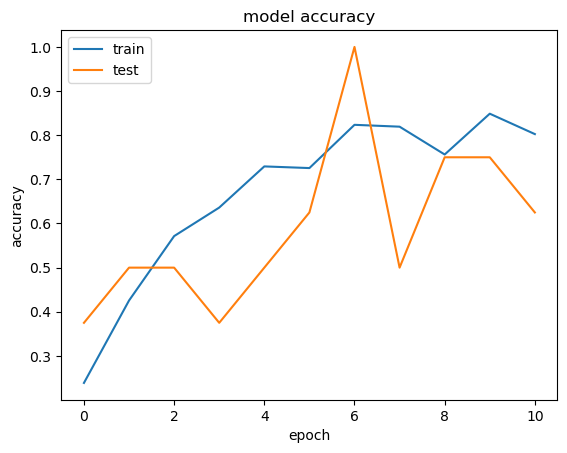

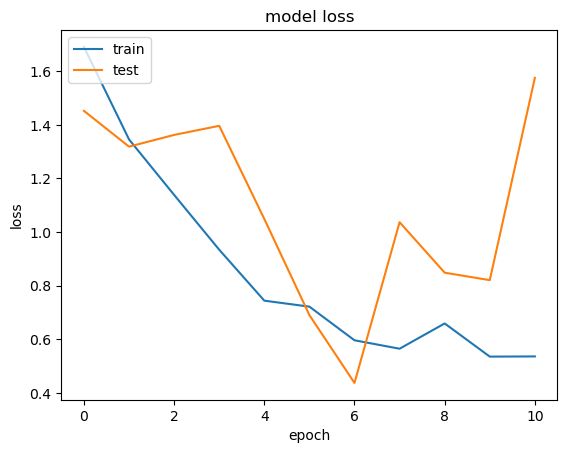

In [24]:
plot_history(history)

| Attribute       | Value    |
|-----------------|----------|
| Best Model      | Model 6  |
| Best Epoch      |          |
| - Epoch Number  | 9        |
| - Accuracy      | 0.7563   |
| - Val Accuracy  | 0.75     |


## MobileNetV2 + GRU

## Model 7

In [26]:
base_model = MobileNetV2(include_top=False)
base_model.trainable = False

model = Sequential()

model.add(TimeDistributed(base_model, input_shape=(len(img_idx), image_size,image_size,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((3,3))))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(GRU(48,  dropout=0.25))


model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


batch_size = 50
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_78 (TimeDi  (None, 13, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 13, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 13, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 13, 1, 1, 1280)    0         
                                                                 
 time_distributed_81 (TimeDi  (None, 13, 1280)         0

Total epochs trained:  15


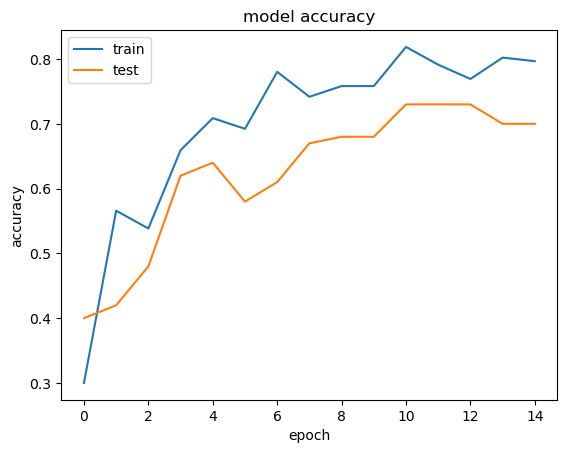

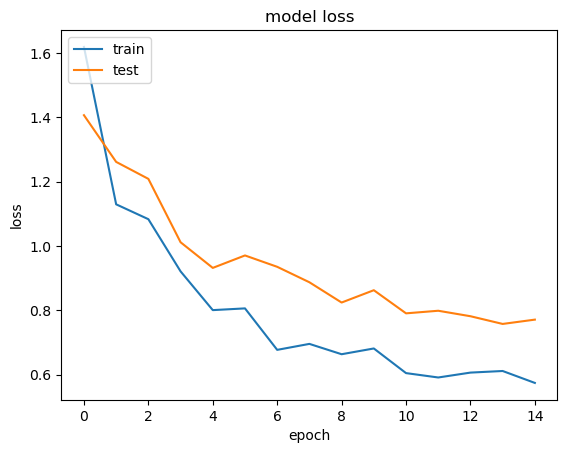

In [27]:
plot_history(history)

This represents the finest model achieved, achieved by decreasing the batch size to enhance the frequency of backpropagations

| Metric        | Value |
|---------------|-------|
| Best epoch    | 12    |
| Accuracy      | 0.79  |
| Val Accuracy  | 0.73  |


## Model 8

In [28]:
base_model = MobileNetV2(include_top=False)
base_model.trainable = False

model = Sequential()

model.add(TimeDistributed(base_model, input_shape=(len(img_idx), image_size,image_size,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((3,3))))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(GRU(48,  dropout=0.25))



model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


batch_size = 32
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_82 (TimeDi  (None, 13, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 13, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 13, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 13, 1, 1, 1280)    0         
                                                                 
 time_distributed_85 (TimeDi  (None, 13, 1280)         0         
 stributed)                                          

Total epochs trained:  10


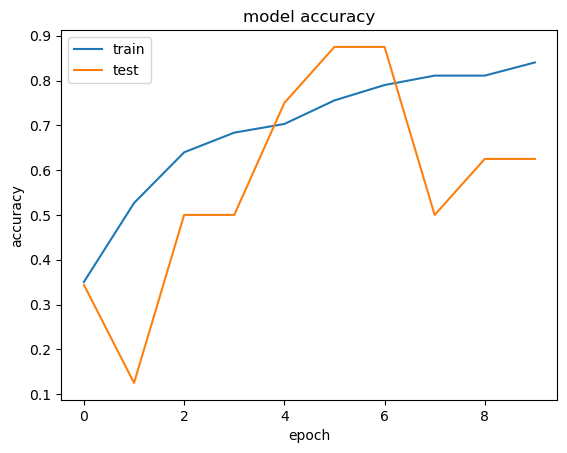

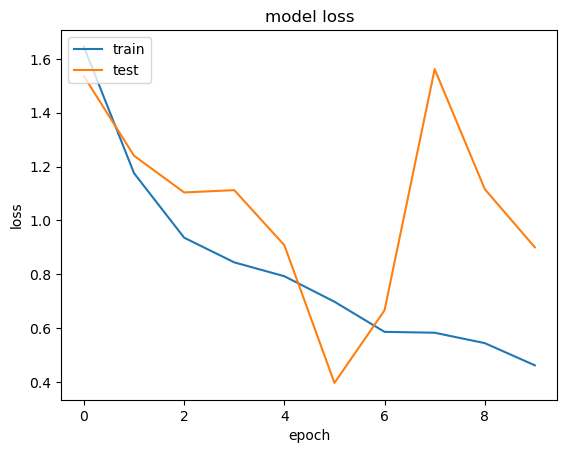

In [29]:
plot_history(history)

Decreasing the batch size proved ineffective.

|                   |       Model       | Accuracy | Val Accuracy |              Decision + Explanation              |
|-------------------|-------------------|----------|--------------|----------------------------------------------------|
|         1         |      Conv3D       |   0.38   |     0.42     | Using 3 CNN layers to capture features from video frames. Batch size: 100, Epochs: 15. Model not crossing 40-50% accuracy; Consider reducing batch size. |
|         2         |      Conv3D       |  0.7143  |     0.75     | Same architecture as Experiment 1, reduced batch size to 32. Model reached 70% accuracy, but still not performing well; Model may not be complex enough. |
|         3         |      Conv3D       |   0.60   |     0.50     | Added a new CNN layer for complexity (4 CNN3D layers). Batch size: 32, Epochs: 15. Model overfitting due to additional CNN layer. |
|         4         |    CNN2D + GRU    |   0.74   |     0.25     | Using 4 CNN2D layers with TimeDistributed layer and GRU. Batch size: 32, Epochs: 15. Model is overfitting due to complexity. |
|         5         |    CNN2D + GRU    |  0.7563  |     0.75     | Removed a CNN2D layer, increased dropout to 0.2. Batch size: 32, Epochs: 15. Model still overfitting but usable. |
|         6         | MobileNetV2 + GRU |   0.79   |     0.73     | Using MobileNetV2 Model with GRU layer. Batch size: 50, Epochs: 15. Best model achieved. Consider reducing batch size for further improvement. |
|         7         | MobileNetV2 + GRU |   0.84   |     0.62     | Same architecture as Experiment 6, reduced batch size to 32. Reducing batch size did not help; Model is overfitting. |

Conclusion of Conv3D Model: Best model is Experiment 2 (Model 2) with Accuracy: 0.7143 and Val Accuracy: 0.7500.

Conclusion of CNN2D + GRU Model: Best model is Experiment 5 with Accuracy: 0.7563 and Val Accuracy: 0.75.

Conclusion of MobileNetV2 + GRU Model: Best model is Experiment 6 with Accuracy: 0.79 and Val Accuracy: 0.73.
